**Purpose**: This document hopes to address concerns about data loss when merging the 10-K filings + metrics, including:
1. Losing ~30% of the 10-K filings
2. Losing ~5% of our stock metrics

**TL;DR** (read the document for graphs/methods):
- 5% of 10-k filings are lost outright because they have CIKs not found in metrics
- Of the other 95%, 16% of the time we have data for 10-K filings but not the predictions for a given (CIK,Year). This accounts for 15% (.95 * .16) of initial 10-k filing rows.
- Joining on different column combinations (using CIK + filing_date, year, or filing_year) makes no difference

**Maybe a different way of combining this data is needed. Still 10% of the 10-K filings unaccounted for.**

- During preprocessing, grouping by CIK and using latest record removes 2% of the text rows. Even if we picked the wrong record every time this wouldn't be significant enough to explain our errors.
- Note that in this code metrics/prediction refer to the stock events, while 10-k/text refer to the 10-k data

In [1]:
import pandas as pd
import numpy as np
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, strip_numeric, strip_punctuation, strip_short, stem_text
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess 10-K filings

In [2]:
# Load CSV
data_by_year = {}
relevant_cols = ["cik", "ticker", "filing_date", "item1a_risk", "item7_mda"]
path = "../Files/"
for year in range(2009,2021):
    data_by_year[year] = pd.read_csv(path + str(year) + ".csv", usecols=relevant_cols)
    data_by_year[year] = data_by_year[year].dropna(subset=['cik', 'item1a_risk', 'item7_mda']).drop_duplicates()
    data_by_year[year]["filing_date"] = pd.to_datetime(data_by_year[year]["filing_date"])
    data_by_year[year]["year"] = year
    data_by_year[year]["filing_year"] =  pd.DatetimeIndex(data_by_year[year]["filing_date"]).year

In [3]:
# Concat all dataframes into a single one
text_dfs = pd.concat(data_by_year.values(), ignore_index=True)
text_dfs.head()

,cik,ticker,filing_date,item1a_risk,item7_mda,year,filing_year
0,23217,CAG,2009-07-24,>ITEM 1A. RISK FACTORS The following factors c...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2009,2009
1,775158,OSK,2009-11-18,>ITEM 1A. RISK FACTORS The Company s financial...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2009,2009
2,1089063,DKS,2009-03-20,>ITEM 1A. RISK FACTORS Risks and Uncertainties...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2009,2009
3,911216,PTN,2009-09-28,>Item 1A. Risk Factors. We expect to continue ...,>Item 7. Management's Discussion and Analysis ...,2009,2009
4,1023459,SLP,2009-11-30,>ITEM 1A RISK FACTORS Not Applicable 11 ITEM...,>ITEM 7 MANAGEMENT S DISCUSSION AND ANALYSIS...,2009,2009


# Load target data

In [4]:
# Load predictions

relevant_cols = ["PERMID", "CIK", "Ticker", "year", "FilingDate", "company_name", "Dividend Payer", "DPS growth", "DPS cut", "zEnvironmental", "dEnvironmental", "sector"]
predictions = pd.read_excel(path + "predictions.xlsx", sheet_name="data", skiprows=32, usecols=relevant_cols)
predictions.columns = ["perm_id", "cik", "ticker", "year", "filing_date", "company_name", "is_dividend_payer", "dps_change", "is_dps_cut", "z_environmental", "d_environmental", "sector"]
predictions['perm_id'] = predictions['perm_id'].str.replace(r"[^0-9]",'')
predictions["filing_date"] = pd.to_datetime(predictions["filing_date"])
predictions["filing_year"] = pd.DatetimeIndex(predictions["filing_date"]).year

""" Difference in filing_date and the year (ticker AA  has 2016 w/ 2017 filing)"""
predictions.head()

,perm_id,cik,ticker,year,filing_date,company_name,is_dividend_payer,dps_change,is_dps_cut,z_environmental,d_environmental,sector,filing_year
0,229,1090872,A,2012,2012-12-20,AGILENT TECHNOLOGIES INC,1.0,0.421053,0.0,2.449925,-1.408006,Health Care,2012
1,229,1090872,A,2013,2013-12-19,AGILENT TECHNOLOGIES INC,1.0,0.137652,0.0,1.666993,1.117957,Health Care,2013
2,229,1090872,A,2014,2014-12-22,AGILENT TECHNOLOGIES INC,1.0,-0.275862,1.0,2.154238,-0.193752,Health Care,2014
3,229,1090872,A,2015,2015-12-21,AGILENT TECHNOLOGIES INC,1.0,0.139535,0.0,2.069083,0.039619,Health Care,2015
4,229,1090872,A,2016,2016-12-20,AGILENT TECHNOLOGIES INC,1.0,0.137652,0.0,2.087030,-0.112717,Health Care,2016


# Explore data pre-merge

**Question** : Are we losing data because there isn't as much CIK overlap between the two datasets? Lets find all of the CIKs that show up in both datasets and try to figure out if the issue is the data itself or the way it is being processed.


**Key Takeaways**:
- 10% of the unique CIKs found in 10-k filings cannot be found in the metrics. This is unlikely to be due to pre-processing because we group by CIK and only remove rows that are duplicates. This accounts for 5% of the actual data in terms of rows. Unless we have some 3rd data source that can help us figure out changing ticker CIKs, it is unlikely this can be changed.
- For CIKs that are found in both, existence of text data and existence of metrics data agree about 80% of the time. This means that 80% of the time we either do not have data for either, or have data for both.

In [5]:
pred_ciks = set(predictions.cik)
text_ciks = set(text_dfs.cik)

intersection = pred_ciks.intersection(text_ciks)
union = pred_ciks.union(text_ciks)
text_only = text_ciks.difference(pred_ciks)
pred_only = pred_ciks.difference(text_ciks)


display("Total of {:n} unique CIKs".format(len(union)))
display("# and % of CIKs in intersection: ({:n},{:.0%})".format(len(intersection), float(len(intersection)) / float(len(union)))) 
display("# and % of CIKs only found in 10-K: ({:n},{:.0%})".format(len(text_only), float(len(text_only)) / float(len(union))))
display("# and % of CIKs only found in metrics: ({:n},{:.0%})".format(len(pred_only), float(len(pred_only)) / float(len(union))))


leftover_textdf = text_dfs[text_dfs["cik"].isin(text_only)]
leftover_preddf = predictions[predictions["cik"].isin(pred_only)]
text_loss_percent = float(len(leftover_textdf)) / float(len(text_dfs))
metric_loss_percent = float(len(leftover_preddf)) / float(len(predictions))

display("CIKs that only appear in the text account for {:.0%} of the text data".format(text_loss_percent))
display("CIKs that only appear in the prediction metrics account for {:.0%} of the metrics data".format(metric_loss_percent))
display("CIKs that only appear in both account for {:.0%} of the text data".format(metric_loss_percent))

common_ciks = sorted(list(intersection))

'Total of 5262 unique CIKs'

'# and % of CIKs in intersection: (4645,88%)'

'# and % of CIKs only found in 10-K: (595,11%)'

'# and % of CIKs only found in metrics: (22,0%)'

'CIKs that only appear in the text account for 5% of the text data'

'CIKs that only appear in the prediction metrics account for 0% of the metrics data'

'CIKs that only appear in both account for 0% of the text data'

In [6]:
""" Define this method to be used below

    For both the 10-K text and metrics for prediction, lets create a 2D binary array where the value
    is 1 if there is a datum for that (cik,year) and 0 otherwise. This 2D array has CIKs by row and year by column.
    Return these binary arrays as well as their logical and (meaning data exists for both) as well as having the
    same value (Not a mismatch)
"""
def find_valid(year_start, year_end, text_col, metrics_col):
    num_years = year_end - year_start + 1
    valid_text = []
    valid_metrics = []
    
    # Find rows in our year range
    textDF = text_dfs[(text_dfs[text_col] >= year_start) & (text_dfs[text_col] <= year_end)]
    metricsDF = predictions[(predictions[metrics_col] >= year_start) & (predictions[metrics_col] <= year_end) ]
    
    # Create the binary heatmap of datum existence
    for cik in common_ciks: #Sorted list of CIKs
        text_binary = [0] * num_years
        
        # Set value to 1 in locations where we have data
        for year in textDF[textDF.cik == cik].loc[:,text_col]:
            text_binary[year - year_start] = 1
        valid_text.append(text_binary)
        
        metric_binary = [0] * num_years
        for year in metricsDF[metricsDF.cik == cik].loc[:,metrics_col]:
            metric_binary[year - year_start] = 1
        valid_metrics.append(metric_binary)
        
    valid_text = np.array(valid_text)
    valid_metrics = np.array(valid_metrics)
    binary_both = np.logical_and(valid_text, valid_metrics)
    binary_same = valid_text == valid_metrics
    binary_text_not_metrics = np.logical_and(valid_text, 1-valid_metrics)
    
    total_datapoints = float(num_years * len(common_ciks))
    display("# and % of present entries in text: ({:n},{:.0%})".format(valid_text.sum(), float(valid_text.sum()) / total_datapoints)) 
    display("# and % of present entries in metrics: ({:n},{:.0%})".format(valid_metrics.sum(), float(valid_metrics.sum()) / total_datapoints)) 
    display("# and % of present entries in text & metrics: ({:n},{:.0%})".format(binary_both.sum(), float(binary_both.sum()) / total_datapoints))
    display("# and % of entries in text & metrics that have the same value: ({:n},{:.0%})".format(binary_same.sum(), float(binary_same.sum()) / total_datapoints))
    display("% of entries where we have a value for the text but not metrics {:.0%}".format(float(binary_text_not_metrics.sum()) / total_datapoints))
    
    return (valid_text, valid_metrics, binary_both, binary_same)

def plot_heatmap(binary_data, title, axis):
    sns.heatmap(data=binary_data, ax=axis)
    axis.set_title(title)
    axis.set_xlabel("Years")
    axis.set_ylabel("CIK Index (Sorted)")

# def plot_heatmap(binary_data, title, axis):
#     colors = [(0,0,0),(1,1,1)]
#     sns.heatmap(data=binary_data, cmap=colors, linewidth=.001, linecolor=(0.1,0.2,0.2), ax=axis)
    
#     colorbar = axis.collections[0].colorbar
#     colorbar.set_ticks([0,1])
#     colorbar.set_ticklabels(["Data","No Data"])

#     axis.set_title(title)
#     axis.set_xlabel("Years")
#     axis.set_ylabel("CIK Index (Sorted)")

### Heatmap when (Text,Metrics) use years from columns ["year","year"] for 2009-2020 on shared CIKs

'# and % of present entries in text: (34563,62%)'

'# and % of present entries in metrics: (26929,48%)'

'# and % of present entries in text & metrics: (25504,46%)'

'# and % of entries in text & metrics that have the same value: (45256,81%)'

'% of entries where we have a value for the text but not metrics 16%'

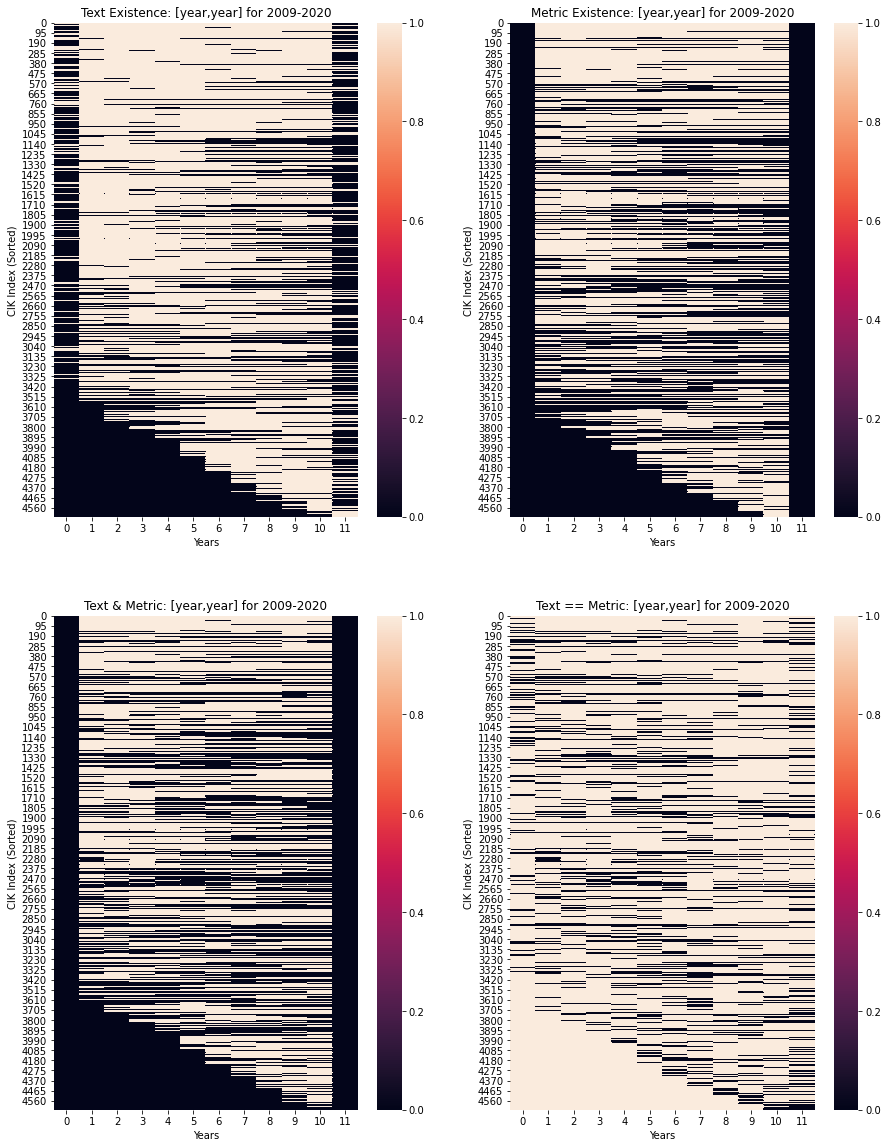

In [7]:
binary_text, binary_metrics, binary_both, binary_same = find_valid(2009,2020, "year", "year")

fig, axs = plt.subplots(2,2, figsize=(15,20))
plot_heatmap(binary_text, "Text Existence: [year,year] for 2009-2020", axs[0,0])
plot_heatmap(binary_metrics, "Metric Existence: [year,year] for 2009-2020", axs[0,1])
plot_heatmap(binary_both, "Text & Metric: [year,year] for 2009-2020", axs[1,0])
plot_heatmap(binary_same, "Text == Metric: [year,year] for 2009-2020", axs[1,1])

### Heatmap when (Text,Metrics) use years from columns ["year","year"] 2012-2020 (Exclude 2009-2011 as we were interested in using just the 10-K text for the LDA corpus for this era, w/o prediction)

'# and % of present entries in text: (27624,66%)'

'# and % of present entries in metrics: (21732,52%)'

'# and % of present entries in text & metrics: (20608,49%)'

'# and % of entries in text & metrics that have the same value: (33665,81%)'

'% of entries where we have a value for the text but not metrics 17%'

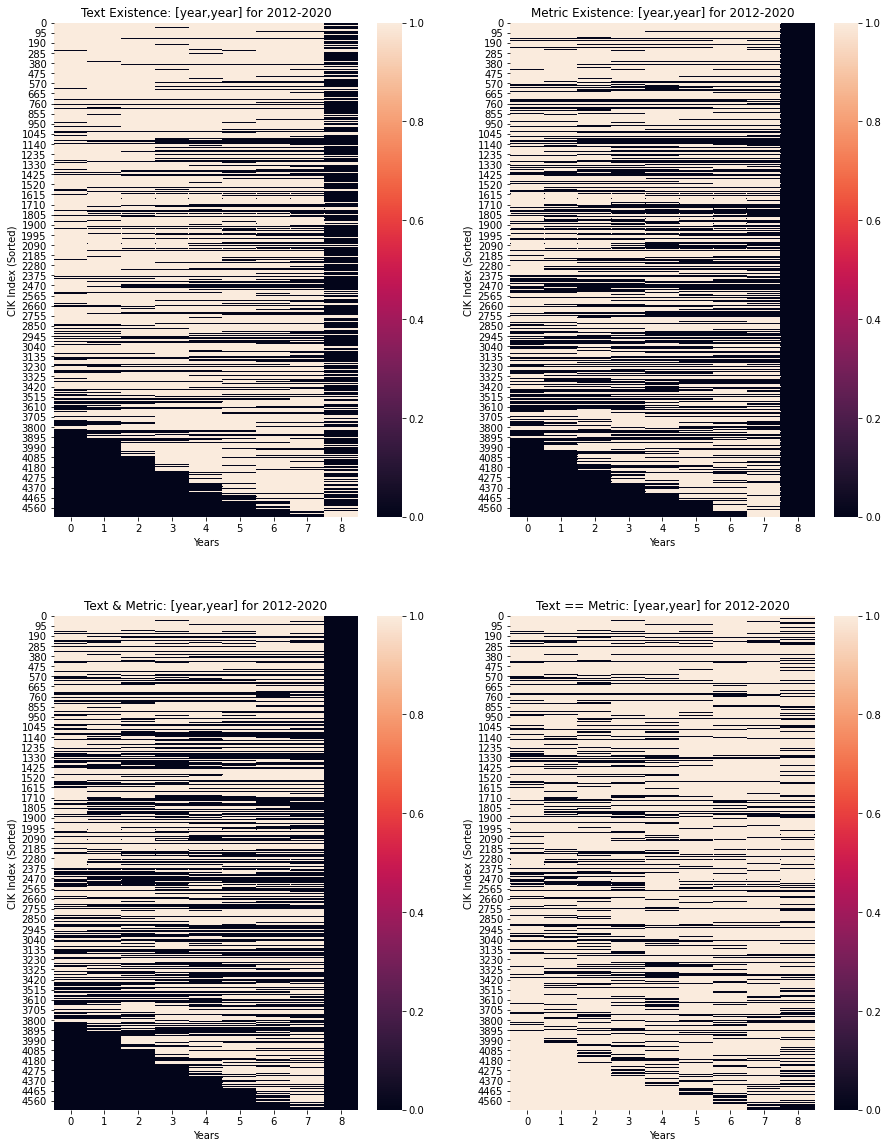

In [8]:
binary_text, binary_metrics, binary_both, binary_same = find_valid(2012,2020, "year", "year")

fig, axs = plt.subplots(2,2, figsize=(15,20))
plot_heatmap(binary_text, "Text Existence: [year,year] for 2012-2020", axs[0,0])
plot_heatmap(binary_metrics, "Metric Existence: [year,year] for 2012-2020", axs[0,1])
plot_heatmap(binary_both, "Text & Metric: [year,year] for 2012-2020", axs[1,0])
plot_heatmap(binary_same, "Text == Metric: [year,year] for 2012-2020", axs[1,1])

### Heatmap when (Text,Metrics) use years from columns ["year","filing_year"] 2009-2020

'# and % of present entries in text: (34563,62%)'

'# and % of present entries in metrics: (26904,48%)'

'# and % of present entries in text & metrics: (25037,45%)'

'# and % of entries in text & metrics that have the same value: (44347,80%)'

'% of entries where we have a value for the text but not metrics 17%'

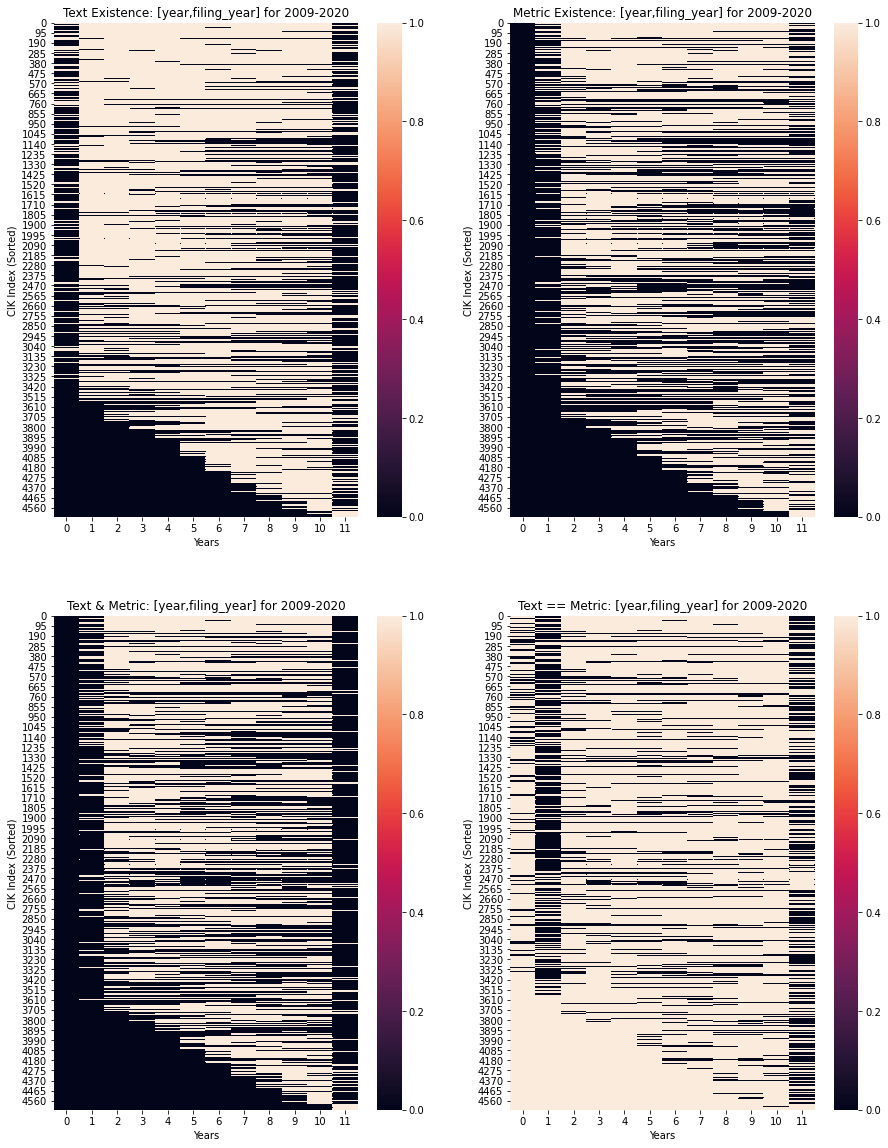

In [9]:
binary_text, binary_metrics, binary_both, binary_same = find_valid(2009,2020, "year", "filing_year")

fig, axs = plt.subplots(2,2, figsize=(15,20))
plot_heatmap(binary_text, "Text Existence: [year,filing_year] for 2009-2020", axs[0,0])
plot_heatmap(binary_metrics, "Metric Existence: [year,filing_year] for 2009-2020", axs[0,1])
plot_heatmap(binary_both, "Text & Metric: [year,filing_year] for 2009-2020", axs[1,0])
plot_heatmap(binary_same, "Text == Metric: [year,filing_year] for 2009-2020", axs[1,1])

### Heatmap when (Text,Metrics) use years from columns ["year","filing_year"] 2012-2020

'# and % of present entries in text: (27624,66%)'

'# and % of present entries in metrics: (23718,57%)'

'# and % of present entries in text & metrics: (21892,52%)'

'# and % of entries in text & metrics that have the same value: (34247,82%)'

'% of entries where we have a value for the text but not metrics 14%'

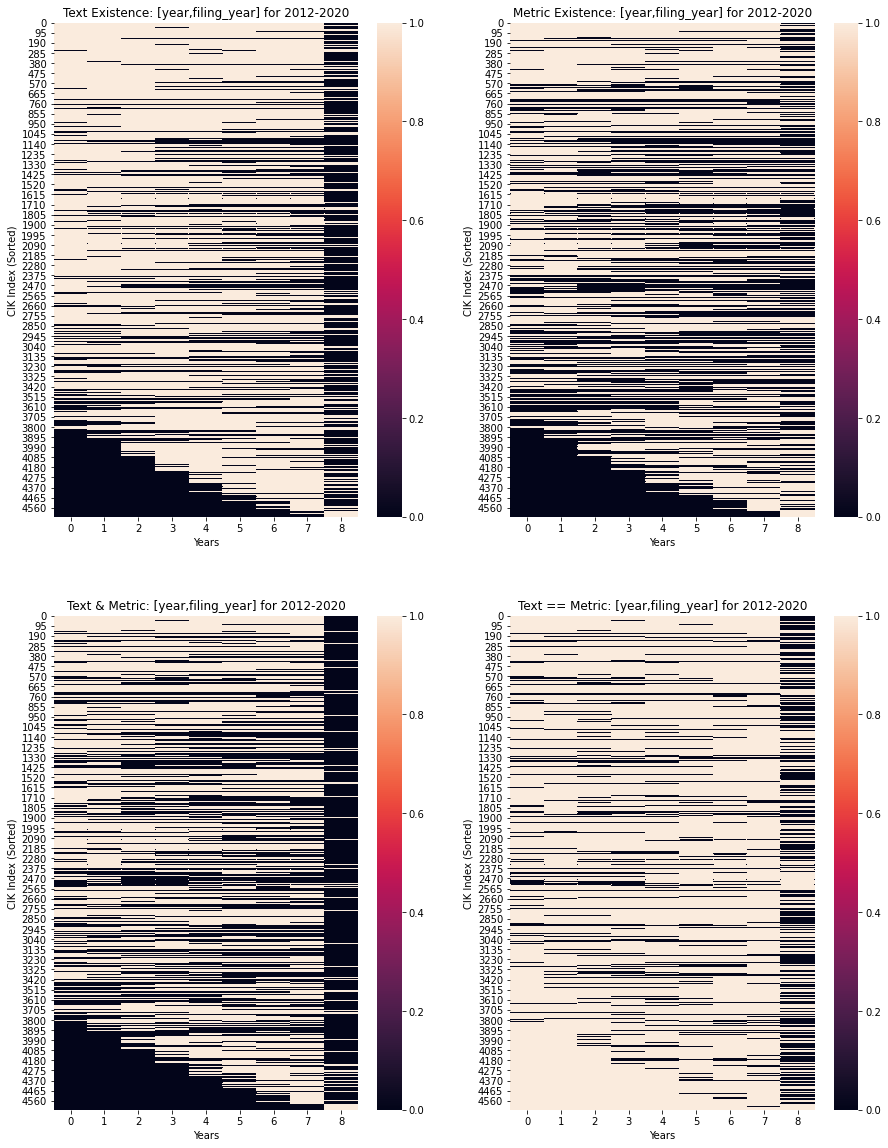

In [12]:
binary_text, binary_metrics, binary_both, binary_same = find_valid(2012,2020, "year", "filing_year")

fig, axs = plt.subplots(2,2, figsize=(15,20))
plot_heatmap(binary_text, "Text Existence: [year,filing_year] for 2012-2020", axs[0,0])
plot_heatmap(binary_metrics, "Metric Existence: [year,filing_year] for 2012-2020", axs[0,1])
plot_heatmap(binary_both, "Text & Metric: [year,filing_year] for 2012-2020", axs[1,0])
plot_heatmap(binary_same, "Text == Metric: [year,filing_year] for 2012-2020", axs[1,1])

# Can merging on different columns help?

Columns of text and metrics include ["cik", "filing_date", "filing_year" "year"]. For text, year is derived from the name of the file (e.g. 2012.csv) while . Metric columns include ["cik", "filing_date", "filing_year", "year"] where filing_year is just the year from filing_date.
- There are 6 different orientations to try (filing_date only matches with itself and we always use CIK)

In [10]:
def merge_stats(text_cols, pred_cols):
    result = pd.merge(text_dfs, predictions, left_on=text_cols, right_on=pred_cols)

    num_result = float(len(result))
    num_text = len(text_dfs)
    num_pred = len(predictions)
    num_text_lost = float(num_text - num_result)
    num_pred_lost = float(num_pred - num_result)

    ticker_mismatch = result["ticker_x"] != result["ticker_y"]
    
    # filing_date_x/y don't exist if we merge on it. Make mismatch = 0
    if ("filing_date" in text_cols) or ("filing_date" in pred_cols):
        filing_date_mismatch = np.array([0] * int(num_result))        
    else:
        filing_date_mismatch = result["filing_date_x"] != result["filing_date_y"]
        
    ticker_and_filing_mismatch = ticker_mismatch & filing_date_mismatch
    ticker_or_filing_mismatch = ticker_mismatch | filing_date_mismatch

    display("Merging on CIK and " + "(" + text_cols[1] + "," + pred_cols[1] +") for (Text,pred)")
    display("     # and % of 10-K filings lost: ({:n},{:.0%})".format(num_text_lost, num_text_lost/ num_text))
    display("     # and % of stock events lost: ({:n},{:.0%})".format(num_pred_lost, num_pred_lost/ num_pred))
    display("     # and % of ticker mismatches: ({:n},{:.0%})".format(ticker_mismatch.sum(), float(ticker_mismatch.sum()) / num_result))
    display("     # and % of filing date mismatches: ({:n},{:.0%})".format(filing_date_mismatch.sum(), float(filing_date_mismatch.sum()) / num_result))
    display("     # and % of ticker and filing date mismatches: ({:n},{:.0%})".format(ticker_and_filing_mismatch.sum(), float(ticker_and_filing_mismatch.sum()) / num_result))
    display("     # and % of ticker or filing date mismatches: ({:n},{:.0%})".format(ticker_or_filing_mismatch.sum(), float(ticker_or_filing_mismatch.sum()) / num_result))

In [11]:
merge_stats(["cik", "filing_date"], ["cik", "filing_date"])
merge_stats(["cik", "filing_year"], ["cik", "filing_year"])
merge_stats(["cik", "year"], ["cik", "year"])
merge_stats(["cik", "year"], ["cik", "filing_year"])
merge_stats(["cik", "filing_year"], ["cik", "year"])

'Merging on CIK and (filing_date,filing_date) for (Text,pred)'

'     # and % of 10-K filings lost: (11592,31%)'

'     # and % of stock events lost: (1502,6%)'

'     # and % of ticker mismatches: (826,3%)'

'     # and % of filing date mismatches: (0,0%)'

'     # and % of ticker and filing date mismatches: (0,0%)'

'     # and % of ticker or filing date mismatches: (826,3%)'

'Merging on CIK and (filing_year,filing_year) for (Text,pred)'

'     # and % of 10-K filings lost: (11535,31%)'

'     # and % of stock events lost: (1445,5%)'

'     # and % of ticker mismatches: (829,3%)'

'     # and % of filing date mismatches: (57,0%)'

'     # and % of ticker and filing date mismatches: (3,0%)'

'     # and % of ticker or filing date mismatches: (883,3%)'

'Merging on CIK and (year,year) for (Text,pred)'

'     # and % of 10-K filings lost: (11141,30%)'

'     # and % of stock events lost: (1051,4%)'

'     # and % of ticker mismatches: (789,3%)'

'     # and % of filing date mismatches: (20132,77%)'

'     # and % of ticker and filing date mismatches: (604,2%)'

'     # and % of ticker or filing date mismatches: (20317,78%)'

'Merging on CIK and (year,filing_year) for (Text,pred)'

'     # and % of 10-K filings lost: (11535,31%)'

'     # and % of stock events lost: (1445,5%)'

'     # and % of ticker mismatches: (829,3%)'

'     # and % of filing date mismatches: (57,0%)'

'     # and % of ticker and filing date mismatches: (3,0%)'

'     # and % of ticker or filing date mismatches: (883,3%)'

'Merging on CIK and (filing_year,year) for (Text,pred)'

'     # and % of 10-K filings lost: (11141,30%)'

'     # and % of stock events lost: (1051,4%)'

'     # and % of ticker mismatches: (789,3%)'

'     # and % of filing date mismatches: (20132,77%)'

'     # and % of ticker and filing date mismatches: (604,2%)'

'     # and % of ticker or filing date mismatches: (20317,78%)'